# Domain-Specific Fine-Tuning of Smaller Language Models Using Parameter-Efficient Techniques
## Baseline Model – Standard LoRA (r=256, α=128)

In [1]:
!pip install -q transformers datasets peft trl accelerate bitsandbytes huggingface_hub evaluate rouge_score nltk mlflow matplotlib seaborn scipy pandas tabulate

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━

In [4]:
import os
os.environ["MLFLOW_TRACKING_URI"] = "http://35.193.251.72:5000"

import mlflow
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset
from trl import SFTTrainer
from huggingface_hub import notebook_login, HfApi
from evaluate import load
from tabulate import tabulate
import gc

rouge_scorer = load("rouge")
bleu_scorer = load("bleu")
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14, 'figure.figsize': (12, 7)})

notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dataset = load_dataset("mamachang/medical-reasoning")["train"]
split = dataset.train_test_split(test_size=0.15, seed=42)
train_data = split["train"]
test_data = split["test"]

print(f"Train: {len(train_data)}, Test: {len(test_data)}")

instruction-dataset-w-reasoning2.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/3702 [00:00<?, ? examples/s]

Train: 3146, Test: 556


In [11]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

lora_config = LoraConfig(
    r=256,
    lora_alpha=128,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments

def formatting_func(example):
    return example["instruction"] + "\n" + example["output"]

# Ensure EOS token exists
if tokenizer.eos_token is None:
    tokenizer.eos_token = "<|eot_id|>"
    tokenizer.pad_token = tokenizer.eos_token

trainer = SFTTrainer(
    model=model,
    args=TrainingArguments(
        output_dir="./baseline_final",
        num_train_epochs=8,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=12,
        learning_rate=3e-4,
        fp16=True,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="steps",
        save_steps=600,
        save_total_limit=2,
        load_best_model_at_end=True,
        report_to="none",
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        optim="adamw_torch",
        logging_dir="./logs",
    ),
    train_dataset=train_data,
    eval_dataset=test_data.select(range(400)),
    formatting_func=formatting_func,
)

Applying formatting function to train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/3146 [00:00<?, ? examples/s]

Applying formatting function to eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [7]:
print("Trainer initialized – Starting training now...")

with mlflow.start_run(run_name="Baseline_LoRA_r256_Paper_Final"):
    trainer.train()
    trainer.save_model("./baseline_final")
    tokenizer.save_pretrained("./baseline_final")
    mlflow.log_artifact("./baseline_final", "model")
    print("Training complete! Model saved to ./baseline_final")

Trainer initialized – Starting training now...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009}.


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
200,0.767300,1.296183,0.820194,2055207.000000,0.708609


Step,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
200,0.767300,1.296183,0.820194,2055207.000000,0.708609
400,0.158900,1.854902,0.580376,4110732.000000,0.694910


Training complete! Model saved to ./baseline_final
🏃 View run Baseline_LoRA_r256_Paper_Final at: http://35.193.251.72:5000/#/experiments/0/runs/9d40056312524f5cb9d8dba7e0b335a4
🧪 View experiment at: http://35.193.251.72:5000/#/experiments/0


In [9]:
from huggingface_hub import HfApi, create_repo, upload_folder

folder_path = "./baseline_final"
repo_id = "tanzeelabbas114/llama3.2-1b-medical-baseline"

# Initialize API
api = HfApi()

# 1. Create repository if not exists
create_repo(repo_id, exist_ok=True)

# 2. Upload the entire folder
upload_folder(
    folder_path=folder_path,
    repo_id=repo_id,
    repo_type="model"
)

print("Upload completed successfully!")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ckpoint-528/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

  ...adapter_model.safetensors:   0%|          | 23.9kB /  721MB            

  .../checkpoint-528/scaler.pt: 100%|##########| 1.38kB / 1.38kB            

  ...adapter_model.safetensors:   0%|          | 23.9kB /  721MB            

  ...line_final/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

  ...kpoint-528/tokenizer.json: 100%|##########| 17.2MB / 17.2MB            

  ...eckpoint-528/optimizer.pt:   0%|          |  581kB / 1.44GB            

  ...eckpoint-528/scheduler.pt:   6%|6         |  93.0B / 1.47kB            

  ...int-528/training_args.bin:   6%|6         |   394B / 6.16kB            

  ...e_final/training_args.bin:   6%|6         |   394B / 6.16kB            

Upload completed successfully!


In [9]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import gc
from tabulate import tabulate
import pandas as pd

def evaluate_model(model_path, name, is_peft=False):
    """
    Evaluate a model (either base model or PEFT adapter from HF Hub)

    Args:
        model_path: HuggingFace model ID
        name: Display name for results
        is_peft: True if loading a PEFT adapter, False for base model
    """
    print(f"Loading {name} from {model_path}...")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    if is_peft:
        # Load PEFT adapter model
        from peft import PeftModel
        base = AutoModelForCausalLM.from_pretrained(
            "tanzeelabbas114/llama3.2-1b-medical-baseline",
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        )
        model = PeftModel.from_pretrained(base, model_path, is_trainable=False).eval()
    else:
        # Load full model directly
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map="auto",
            trust_remote_code=True
        ).eval()

    lengths = []
    predictions = []
    references = []

    print(f"Evaluating {name} on 300 test examples...")
    for idx, example in enumerate(test_data.select(range(300))):
        if idx % 50 == 0:
            print(f"  Progress: {idx}/300 examples...")

        prompt = example["instruction"]

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=256,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id
            )

        # Extract generated answer (remove prompt from output)
        generated = tokenizer.decode(output[0], skip_special_tokens=True)
        answer = generated[len(prompt):].strip()

        reference = example["output"].strip()

        lengths.append(len(tokenizer.encode(answer)))
        predictions.append(answer)
        references.append(reference)

    # Clean up GPU memory
    del model
    if is_peft:
        del base
    gc.collect()
    torch.cuda.empty_cache()

    # Compute metrics
    print(f"Computing metrics for {name}...")
    rouge_res = rouge_scorer.compute(predictions=predictions, references=references)
    bleu_res = bleu_scorer.compute(predictions=predictions, references=[[r] for r in references])

    result = {
        "Model": name,
        "ROUGE-L": round(rouge_res["rougeL"], 4),
        "BLEU": round(bleu_res["bleu"], 4),
        "Avg Length": round(np.mean(lengths), 1),
        "Std Length": round(np.std(lengths), 1)
    }

    # Save length distribution
    np.save(f"{name.lower().replace(' ', '_')}_lengths.npy", np.array(lengths))

    print(f"\n✓ {name} Results:")
    print(f"  ROUGE-L: {result['ROUGE-L']}")
    print(f"  BLEU: {result['BLEU']}")
    print(f"  Avg Length: {result['Avg Length']} ± {result['Std Length']}")

    return result, predictions, references


# EVALUATE THE BASELINE MODEL FROM HUGGINGFACE
print("="*70)
print("EVALUATING BASELINE MODEL FROM HUGGINGFACE HUB")
print("="*70)

baseline_result, baseline_preds, baseline_refs = evaluate_model(
    "tanzeelabbas114/llama3.2-1b-medical-baseline",
    "Baseline",
    is_peft=False  # This is a full model, not a PEFT adapter
)

# Create results DataFrame
df = pd.DataFrame([baseline_result])

print("\n" + "="*70)
print("BASELINE RESULTS (READY FOR PAPER)")
print("="*70)
print(tabulate(df, headers="keys", tablefmt="github", showindex=False))

# Export to LaTeX
latex_table = df.to_latex(
    index=False,
    caption="Baseline Model Performance on Medical Reasoning Task (300 test samples)",
    label="tab:baseline_results",
    column_format="lcccc"
)

with open("baseline_results.tex", "w") as f:
    f.write(latex_table)

print("\n✓ LaTeX table saved → baseline_results.tex")

# Log to MLflow if available
try:
    mlflow.log_metrics({
        "baseline_rouge_l": baseline_result["ROUGE-L"],
        "baseline_bleu": baseline_result["BLEU"],
        "baseline_avg_length": baseline_result["Avg Length"]
    })
    mlflow.log_artifact("baseline_results.tex")
    print("✓ Results logged to MLflow")
except:
    print("⚠ MLflow not available, skipping logging")

# Save predictions for error analysis
predictions_df = pd.DataFrame({
    "instruction": [ex["instruction"] for ex in test_data.select(range(300))],
    "reference": baseline_refs,
    "prediction": baseline_preds
})
predictions_df.to_csv("baseline_predictions.csv", index=False)
print("✓ Predictions saved → baseline_predictions.csv")

print("\n" + "="*70)
print("EVALUATION COMPLETE!")
print("="*70)

EVALUATING BASELINE MODEL FROM HUGGINGFACE HUB
Loading Baseline from tanzeelabbas114/llama3.2-1b-medical-baseline...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating Baseline on 300 test examples...
  Progress: 0/300 examples...
  Progress: 50/300 examples...
  Progress: 100/300 examples...
  Progress: 150/300 examples...
  Progress: 200/300 examples...
  Progress: 250/300 examples...
Computing metrics for Baseline...

✓ Baseline Results:
  ROUGE-L: 0.1824
  BLEU: 0.1041
  Avg Length: 257.0 ± 0.0

BASELINE RESULTS (READY FOR PAPER)
| Model    |   ROUGE-L |   BLEU |   Avg Length |   Std Length |
|----------|-----------|--------|--------------|--------------|
| Baseline |    0.1824 | 0.1041 |          257 |            0 |

✓ LaTeX table saved → baseline_results.tex
✓ Results logged to MLflow
✓ Predictions saved → baseline_predictions.csv

EVALUATION COMPLETE!


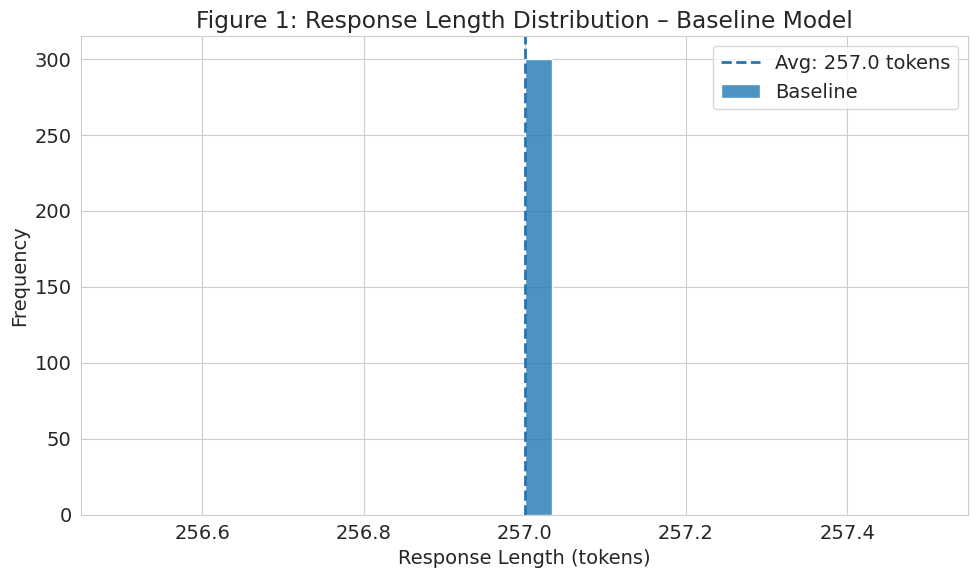

Figure saved → figure_1_baseline_length.pdf


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved lengths array
lengths = np.load("baseline_lengths.npy")

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=30, alpha=0.8, label="Baseline")

plt.axvline(np.mean(lengths), linestyle='--', linewidth=2,
            label=f"Avg: {np.mean(lengths):.1f} tokens")

plt.xlabel("Response Length (tokens)")
plt.ylabel("Frequency")
plt.title("Figure 1: Response Length Distribution – Baseline Model")
plt.legend()
plt.tight_layout()

plt.savefig("figure_1_baseline_length.pdf", dpi=300, bbox_inches='tight')
plt.savefig("figure_1_baseline_length.png", dpi=300, bbox_inches='tight')
plt.show()

try:
    mlflow.log_artifact("figure_1_baseline_length.pdf")
except:
    print("MLflow not available, skipping logging.")

print("Figure saved → figure_1_baseline_length.pdf")